In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import requests
from collections import Counter

In [49]:
pd.set_option('display.max_columns', 50)

# Creating the dataframes

In [3]:
countries = ['US', 'DE', 'CA', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
dframes = [code.lower()+'_df' for code in countries]

cat_ids = pd.read_csv('yt category list.csv', delimiter=' - ', engine='python')
for code, df in zip(countries, dframes):
    globals()[df] = pd.read_csv(f'{code}videos.csv', parse_dates=['trending_date', 'publish_time'], \
                                encoding_errors='ignore').merge(cat_ids, on='category_id', how='inner')\
                                .drop(['category_id', 'thumbnail_link'], axis=1)
    
us_df.head(1)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs


In [4]:
# we now have a dataframe for each of the countries
# we need to merge and identify the dataframes we've merged

df_list = []
for code, df in zip(countries, dframes):
    globals()[df]['country'] = code
    df_list.append(globals()[df])
    
df = pd.concat(df_list)
df.head(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category,country
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US
1,0mlNzVSJrT0,17.14.11,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US


# Cleaning up the raw data

In [5]:
# lets first remove some bias
# this will be videos with comments or ratings disabled
# this will also be videos with errors or has been removed

print(len(df))

df = df[~(df['comments_disabled'] | \
          df['ratings_disabled'] | \
          df['video_error_or_removed']) == True]

df = df.drop(['comments_disabled', 
              'ratings_disabled', 
              'video_error_or_removed'], axis=1)

375942


In [6]:
# lets also get rid of any null values, if existent
df = df.dropna()

In [7]:
# it also wouldn't be helpful to have nans in values later on
# so we'll remove any rows with int 0 in it
df = df.drop(df[df.isin([0]).any(axis = 1)].index)

In [8]:
# trending date is of type object, which is not valuable to us.
# lets make that a datetime object, then aggregate to find how long a video will take to trend

df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['trending_delta'] = df['trending_date'] - df['publish_time'].dt.tz_localize(None)
df['trending_delta'] = df['trending_delta'].dt.days + 1
df.head(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207


In [9]:
# another thing we can do is extract the datetime from publish_time
df['hour'] = df['publish_time'].dt.hour
df['day'] = df['publish_time'].dt.day
df['week'] = df['publish_time'].dt.day_name()
df['month'] = df['publish_time'].dt.month_name()
df['year'] = df['publish_time'].dt.year
df.head(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1,17,13,Monday,November,2017
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207,6,21,Friday,April,2017


In [10]:
# it looks like we have barely any data for July - October
# Since we have almost no data for this, it's better to fully exclude these rows
# as we don't want to create false interpretations of it
df['month'].value_counts()

df = df[~df['publish_time'].dt.month.isin(range(7, 11))]

In [11]:
# now that we've cleaned up the dataframe, we should reset the index
df = df.reset_index().drop('index', axis=1)
df.tail(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year
315891,UHIzVGIwH4g,2018-06-14,"Деревня, которая не вымрет",varlamov,2018-06-13 14:18:05+00:00,"Голландия|""Нидерланды""|""Амстердам""|""каналы Амс...",62681,4196,51,759,"Сказочная Голландия! Пряничные домики, узкие у...",Travel & Events,RU,1,14,13,Wednesday,June,2018
315892,9c-eJf_BcMw,2018-01-02,Снежная королева 3. Огонь и лед,Три богатыря,2018-01-01 09:00:13+00:00,"Снежная королева|""Снежная королева 3""|""Снежная...",100049,1732,138,196,Редкий дар ввязываться во всевозможные неприят...,Movies,RU,1,9,1,Monday,January,2018


# Analysis

In [57]:
sns.set(rc = {'figure.figsize':(15, 7)})
sns.set_style('white')

In [52]:
# lets also mutate columns for better analysis

df['like_feedback'] = 100 * round(df['comment_count'] / (df['likes']), 2) # engagement ratio
df['dislike_feedback'] = 100 * round(df['comment_count'] / (df['dislikes']), 2) # engagement ratio
df['len_title'] = df['title'].str.findall(r'[.]*').str.len() # count chars in title
df['len_desc'] = df['description'].str.split(' ').str.len() # count chars in desc
df['pct_cap'] = 100 * round(df['title'].str.findall(r'[A-Z]').str.len() /
                df['title'].str.findall(r'[A-Za-z]').str.len(), 2) # ratio of cap letters in title
df['qty_tags'] = df['tags'].str.split('|').str.len() # count number of tags

df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year,like_feedback,dislike_feedback,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207,6,21,Friday,April,2017,21.0,289.0,21,16,24.0,4
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,US,3,15,11,Saturday,November,2017,20.0,51.0,76,57,79.0,44


## What is the main ingredient for a successful trending video?

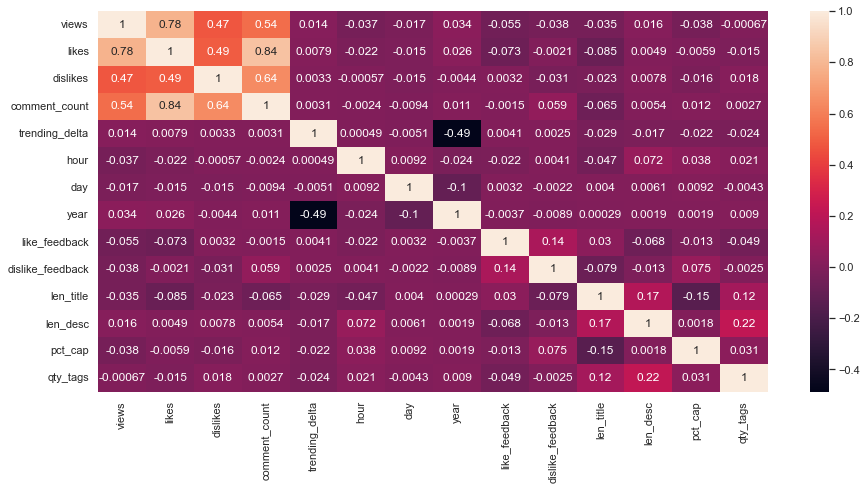

In [58]:
# lets create a correlation matrix with the base data and see what we get
sns.heatmap(df.corr(), annot=True)
plt.show()

In [59]:
df.head()

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year,like_feedback,dislike_feedback,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207,6,21,Friday,April,2017,21.0,289.0,21,16,24.0,4
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,US,3,15,11,Saturday,November,2017,20.0,51.0,76,57,79.0,44
3,KODzih-pYlU,2017-11-14,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,2017-11-11 18:08:04+00:00,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062,7250,217,456,Molly is an god damn amazing human and she cha...,People & Blogs,US,3,18,11,Saturday,November,2017,6.0,210.0,73,78,53.0,12
4,8mhTWqWlQzU,2017-11-14,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,2017-11-11 01:19:33+00:00,wearing online dollar store makeup for a week|...,2744430,115426,1110,6541,I found this online dollar store called ShopMi...,People & Blogs,US,3,1,11,Saturday,November,2017,6.0,589.0,46,75,21.0,25


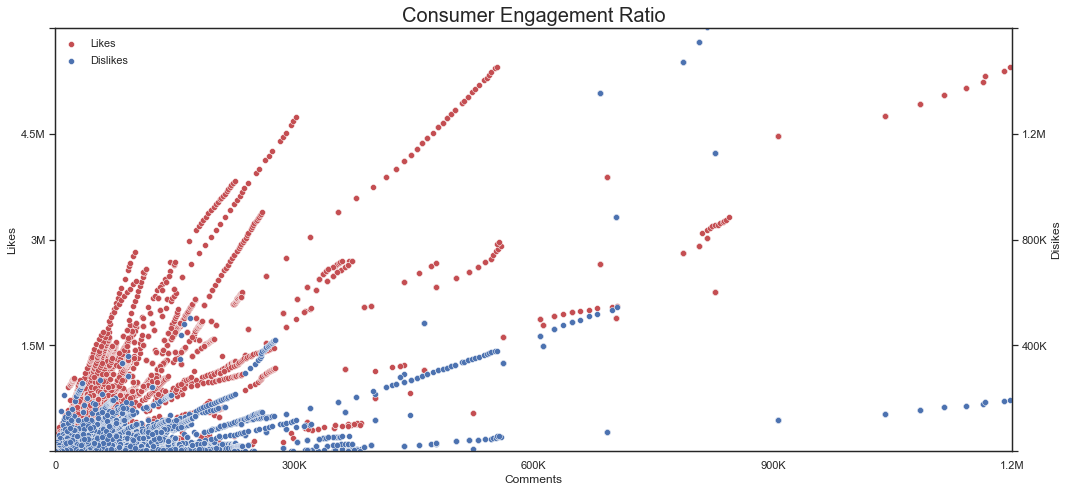

In [60]:
# there's also an obvious trend between the amount of likes/dislikes and the interactions (comments) people have

fig1 = sns.scatterplot(x = 'comment_count', y = 'likes', data = df, label = 'Likes', color = 'r')
fig2 = sns.scatterplot(x = 'comment_count', y = 'dislikes', data=df, color = 'b', 
                           label = 'Dislikes', ax = plt.twinx())

fig1.set(xlim = (0, 1.2e6), xlabel = 'Comments', 
         ylim = (0, 6e6), ylabel = 'Likes', 
         xticks = [0, 3e5, 6e5, 9e5, 1.2e6],
         yticks = [0, 1.5e6, 3e6, 4.5e6, 6e6],
         xticklabels = ['0', '300K', '600K', '900K', '1.2M'], 
         yticklabels = ['', '1.5M', '3M', '4.5M', ''])


fig2.set(ylim = (0, 1.6e6), ylabel = 'Disikes',
         yticks = [0, 4e5, 8e5, 1.2e6, 1.6e6],
         yticklabels = ['', '400K', '800K', '1.2M', ''])


sns.move_legend(fig1, loc = (0, 0.94), frameon = False)
sns.move_legend(fig2, loc = (0, 0.9), frameon = False)

plt.title('Consumer Engagement Ratio', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Engagement Ratio - Scatter.png', dpi = 600)
plt.show()

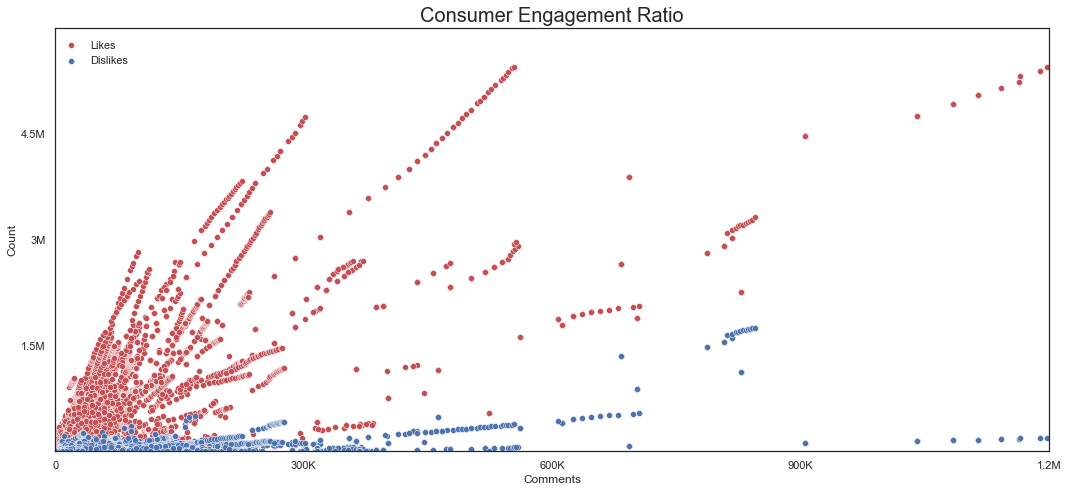

In [181]:
# there's also an obvious trend between the amount of likes/dislikes and the interactions (comments) people have

fig1 = sns.scatterplot(x = 'comment_count', y = 'likes', data = df, label = 'Likes', color = 'r')
fig2 = sns.scatterplot(x = 'comment_count', y = 'dislikes', data=df, color = 'b', 
                           label = 'Dislikes')

fig1.set(xlim = (0, 1.2e6), xlabel = 'Comments', 
         ylim = (0, 6e6), ylabel = 'Count', 
         xticks = [0, 3e5, 6e5, 9e5, 1.2e6],
         yticks = [0, 1.5e6, 3e6, 4.5e6, 6e6],
         xticklabels = ['0', '300K', '600K', '900K', '1.2M'], 
         yticklabels = ['', '1.5M', '3M', '4.5M', ''])


sns.move_legend(fig1, loc = (0, 0.94), frameon = False)
sns.move_legend(fig2, loc = (0, 0.9), frameon = False)

plt.title('Consumer Engagement Ratio', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Engagement Ratio - Scatter.png', dpi = 600)
plt.show()

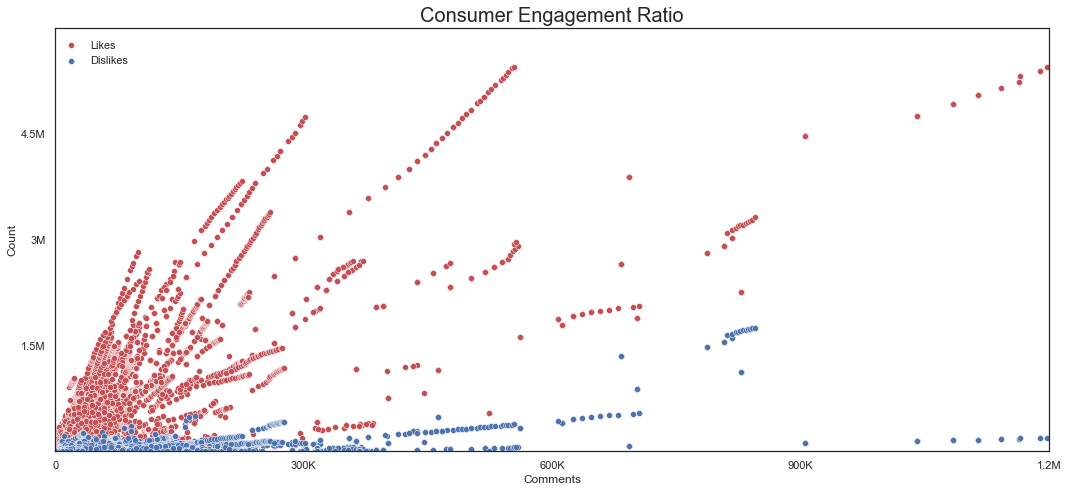

In [181]:
# there's also an obvious trend between the amount of likes/dislikes and the interactions (comments) people have

fig1 = sns.scatterplot(x = 'comment_count', y = 'likes', data = df, label = 'Likes', color = 'r')
fig2 = sns.scatterplot(x = 'comment_count', y = 'dislikes', data=df, color = 'b', 
                           label = 'Dislikes')

fig1.set(xlim = (0, 1.2e6), xlabel = 'Comments', 
         ylim = (0, 6e6), ylabel = 'Count', 
         xticks = [0, 3e5, 6e5, 9e5, 1.2e6],
         yticks = [0, 1.5e6, 3e6, 4.5e6, 6e6],
         xticklabels = ['0', '300K', '600K', '900K', '1.2M'], 
         yticklabels = ['', '1.5M', '3M', '4.5M', ''])


sns.move_legend(fig1, loc = (0, 0.94), frameon = False)
sns.move_legend(fig2, loc = (0, 0.9), frameon = False)

plt.title('Consumer Engagement Ratio', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Engagement Ratio - Scatter.png', dpi = 600)
plt.show()

In [164]:
df['likes'].median() / df['dislikes'].median()

20.409523809523808

In [179]:
df2 = df.groupby('category').agg({'likes': 'median', 'views': 'median', 
                                 'dislikes': 'median', 'comment_count': 'median'})
df2['comment_count'] / df2['views']

category
 Film & Animation        0.002941
Autos & Vehicles         0.005135
Comedy                   0.003404
Education                0.005040
Entertainment            0.002640
Gaming                   0.005174
Howto & Style            0.004275
Movies                   0.001402
Music                    0.002627
News & Politics          0.003486
Nonprofits & Activism    0.004573
People & Blogs           0.003123
Pets & Animals           0.004176
Science & Technology     0.005069
Shows                    0.000819
Sports                   0.002139
Travel & Events          0.003926
dtype: float64

In [165]:
print(df['comment_count'].median() / df['views'].median())
print(df['comment_count'].median() / df['likes'].median())
print(df['comment_count'].median() / df['dislikes'].median())

0.0030677156814998166
0.1425571628558096
2.9095238095238094


In [146]:
df['likes'].mean() / df['dislikes'].mean()

18.689446387689916

In [147]:
df['likes'].median() / df['dislikes'].median()

20.409523809523808

In [145]:
print(df['comment_count'].mean() / df['likes'].mean())
print(df['comment_count'].mean() / df['dislikes'].mean())

0.11055786081108619
2.066265212366479


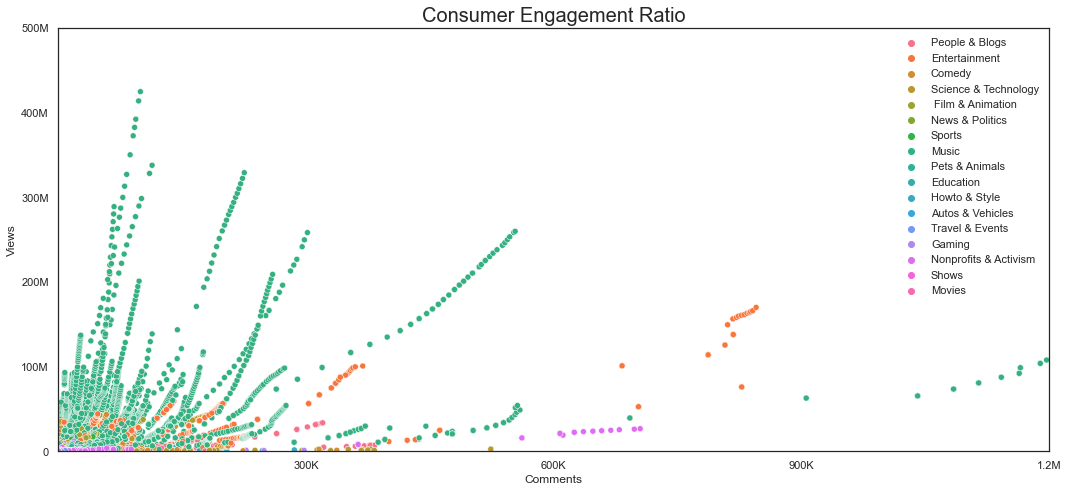

In [180]:
# as expected, we see a strong positive correlations between views and likes/dislikes

fig = sns.scatterplot(y = 'views', x = 'comment_count', data = df, hue = 'category')

fig.set(ylim = (0, 5e8), ylabel = 'Views', 
        xlim = (0, 1.2e6), xlabel = 'Comments',
        yticks = [0, 1e8, 2e8, 3e8, 4e8, 5e8], 
        xticks = [0, 3e5, 6e5, 9e5, 1.2e6], 
        yticklabels = ['0', '100M', '200M', '300M', '400M', '500M'], 
        xticklabels = ['', '300K', '600K', '900K', '1.2M'])

plt.legend(frameon = False)
plt.title('Consumer Engagement Ratio', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Engagement Ratio Category - Scatter.png', dpi = 600)
plt.show()

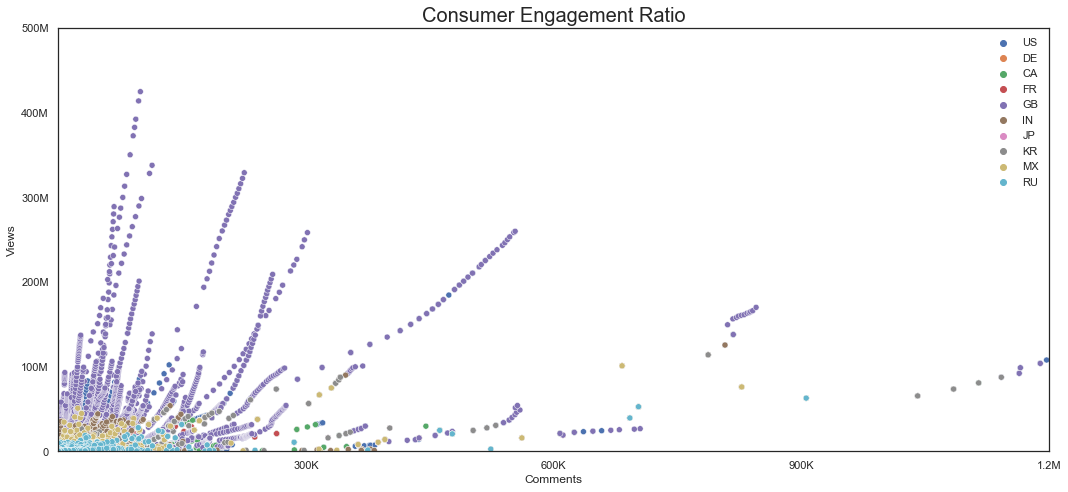

In [101]:
# as expected, we see a strong positive correlations between views and likes/dislikes

fig = sns.scatterplot(y = 'views', x = 'comment_count', data = df, hue = 'country')

fig.set(ylim = (0, 5e8), ylabel = 'Views', 
        xlim = (0, 1.2e6), xlabel = 'Comments',
        yticks = [0, 1e8, 2e8, 3e8, 4e8, 5e8], 
        xticks = [0, 3e5, 6e5, 9e5, 1.2e6], 
        yticklabels = ['0', '100M', '200M', '300M', '400M', '500M'], 
        xticklabels = ['', '300K', '600K', '900K', '1.2M'])

plt.legend(frameon = False)
plt.title('Consumer Engagement Ratio', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Engagement Ratio Global - Scatter.png', dpi = 600)
plt.show()

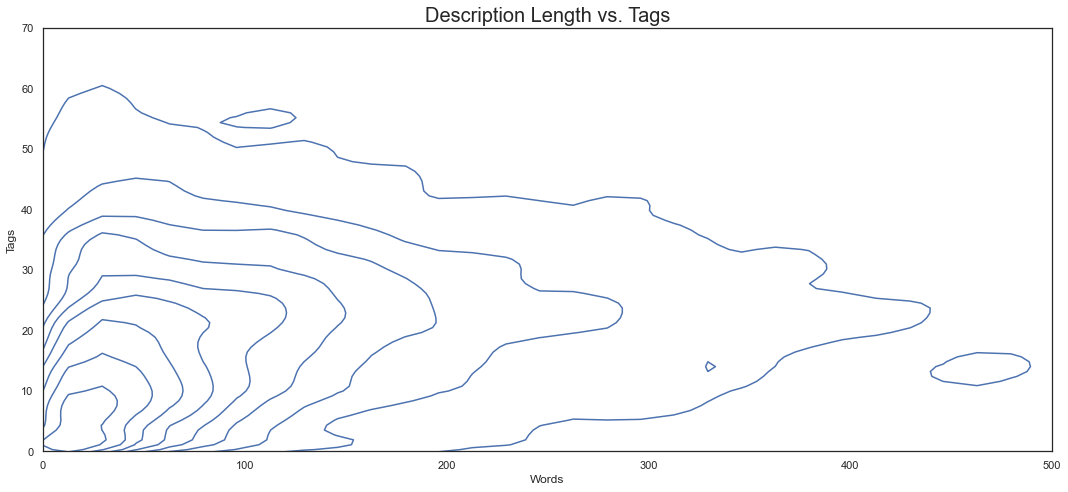

In [62]:
fig = sns.kdeplot(x='len_desc', y='qty_tags', data=df, palette='Set2')

fig.set(xlim = (0, 500), xlabel = 'Words', 
        ylim = (0, 70), ylabel = 'Tags')

plt.title('Description Length vs. Tags', fontsize = 20)
plt.tight_layout()
plt.savefig('Words and Tags - Density.png', dpi = 600)
plt.show()

## Let's group by category and perform some aggregations and analysis

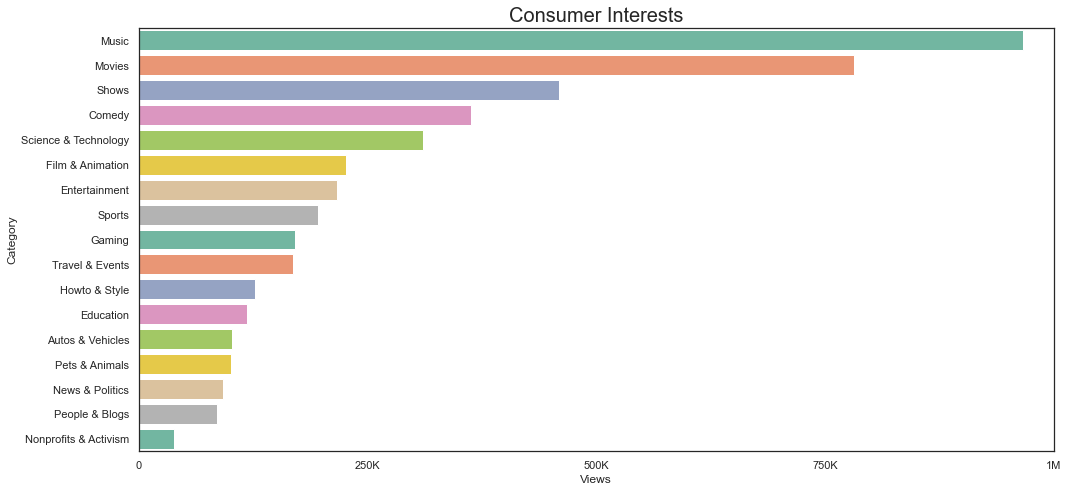

In [109]:
# we can group by categories and plot viewcount by its median
# as there are many outliers, the median tends to be a better metric than the mean

data = df.groupby('category').median().reset_index()
data = data.sort_values('views', ascending=False)
fig = sns.barplot(x='views', y='category', data = data, palette = 'Set2')

fig.set(xlim = (0, 1e6), xlabel = 'Views', 
        ylabel = 'Category',
        xticks = [0, 2.5e5, 5e5, 7.5e5, 1e6],
        xticklabels = ['0', '250K', '500K', '750K', '1M'])

plt.title('Consumer Interests', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Interests - Bar.png', dpi = 600)
plt.show()

## Analyzing video metrics

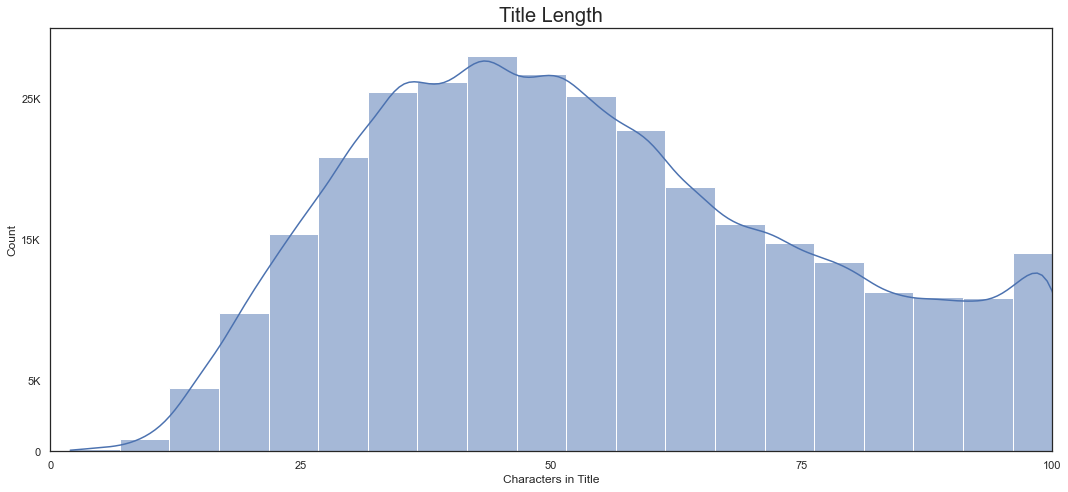

In [64]:
# from here, we can see that the average video title length is ~40-60 characters long
# with this information, we can make predictions on the attentive-ness of viewers

fig = sns.histplot(x=df['len_title'], data=df, kde=True, bins=20)

fig.set(xlim = (0, 100), xlabel = 'Characters in Title', 
        ylim = (0, 3e4), ylabel = 'Count',
        xticks = [0, 25, 50, 75, 100], 
        yticks = [0, 5e3, 15e3, 25e3], 
        yticklabels = ['0', '5K', '15K', '25K'])

plt.title('Title Length', fontsize = 20)
plt.tight_layout()
plt.savefig('Title Length - Histogram.png', dpi = 600)
plt.show()

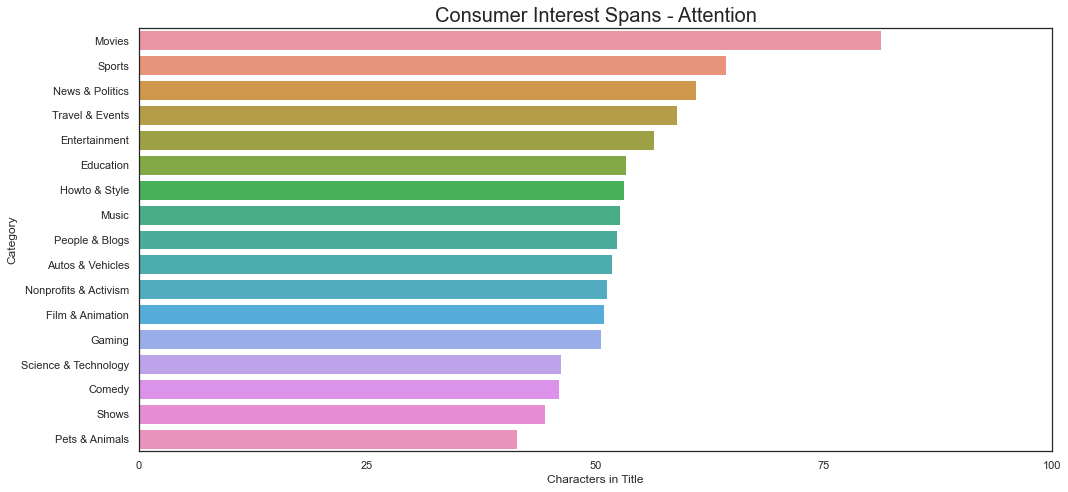

In [113]:
# we can group by categories and plot viewcount by its median
# as there are many outliers, the median tends to be a better metric than the mean

data = df.groupby('category').agg({'len_title': 'mean'}).reset_index()
data = data.sort_values('len_title', ascending=False)
fig = sns.barplot(x = 'len_title', y = 'category', data = data)

fig.set(xlim = (0, 100), xlabel = 'Characters in Title', 
        ylabel = 'Category',
        xticks = [0, 25, 50, 75, 100])

plt.title('Consumer Interest Spans - Attention', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Interest Span Attention - Bar.png', dpi = 600)
plt.show()

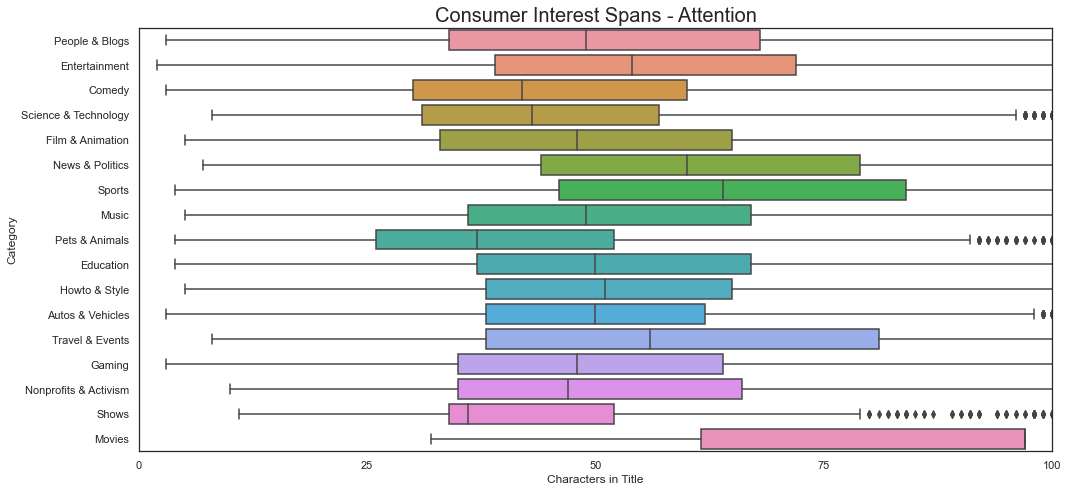

In [114]:
# however, we can see a more detailed view when we split the length by category
# it looks like the deviation sports and travel have the highest spread
# we can confirm that too by looking at the standard deviation values

fig = sns.boxplot(x = 'len_title', y = 'category', data = df)

fig.set(xlim = (0, 100), xlabel = 'Characters in Title', 
        ylabel = 'Category',
        xticks = [0, 25, 50, 75, 100])

plt.title('Consumer Interest Spans - Attention', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Interest Span Attention - Boxplot.png', dpi = 600)
plt.show()

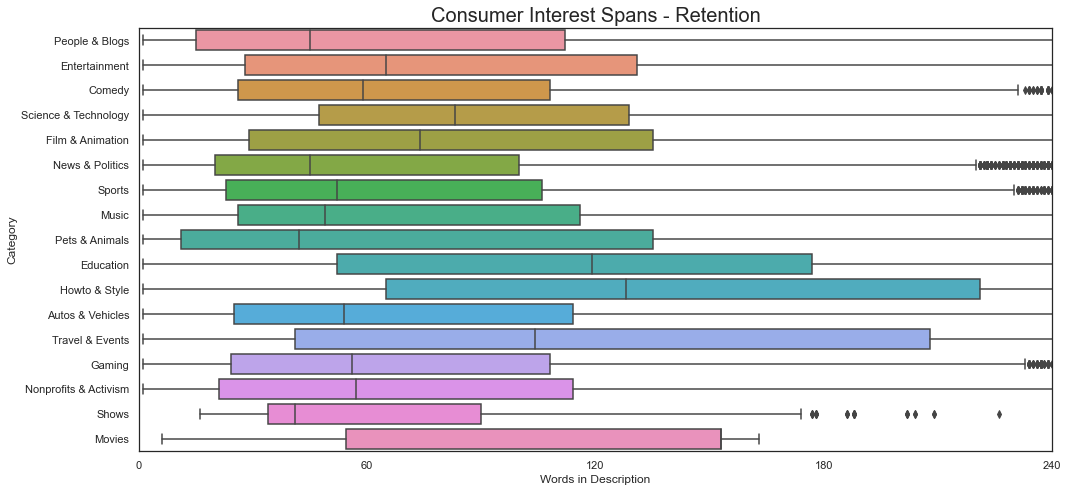

In [115]:
# however, we can see a more detailed view when we split the length by category
# it looks like the deviation sports and travel have the highest spread
# we can confirm that too by looking at the standard deviation values

fig = sns.boxplot(x = 'len_desc', y = 'category', data = df)

fig.set(xlim = (0, 240), xlabel = 'Words in Description', 
        ylabel = 'Category',
        xticks = [0, 60, 120, 180, 240])

plt.title('Consumer Interest Spans - Retention', fontsize = 20)
plt.tight_layout()
plt.savefig('Consumer Interest Span Retention - Boxplot.png', dpi = 600)
plt.show()

In [68]:
# we can now analyze the tags
# first, lets make a copy

df_tags = df.copy()
df_tags['tags'] = df_tags['tags'].apply(lambda x: x.split('|'))
df_tags.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year,like_feedback,dislike_feedback,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,[SHANtell martin],748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"[cute, ""cats"", ""thai"", ""eggs""]",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207,6,21,Friday,April,2017,21.0,289.0,21,16,24.0,4
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"[shawn johnson, ""andrew east"", ""shawn east"", ""...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,US,3,15,11,Saturday,November,2017,20.0,51.0,76,57,79.0,44


In [69]:
idx = 0
lst = []

for tag in df_tags['tags']:
    lst.extend(map(lambda x: [idx, x], tag))
    idx += 1
    
tags = pd.DataFrame(lst, columns = ['index', 'tags'])
tags['tags'] = tags['tags'].str.strip('""').str.lower()
tags.head(3)

,index,tags
0,0,shantell martin
1,1,cute
2,1,cats


In [70]:
df_tag = df_tags.drop('tags', axis = 1).merge(right = tags, how = 'right', 
                                               left_index = True, right_on = 'index')

In [71]:
df_tag['tags'].value_counts().head(15)

[none]           22215
funny            15788
comedy           14325
2018              9870
news              7688
music             7442
video             5926
trailer           5397
pop               5280
rap               5003
humor             4948
tv                4893
2017              4876
television        4671
entertainment     4487
Name: tags, dtype: int64

In [72]:
df_tag['tags'].value_counts().head(15)

top10_tags = ['funny', 'comedy', 'news', 'music', 'video', 
              'trailer', 'pop', 'rap', 'humor', 'tv']

df_tag = df_tag[df_tag['tags'].isin(top10_tags)]

## Energy usage

/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_5959/667438291.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig1.set(xlim = (0, 23), xlabel = 'Time',


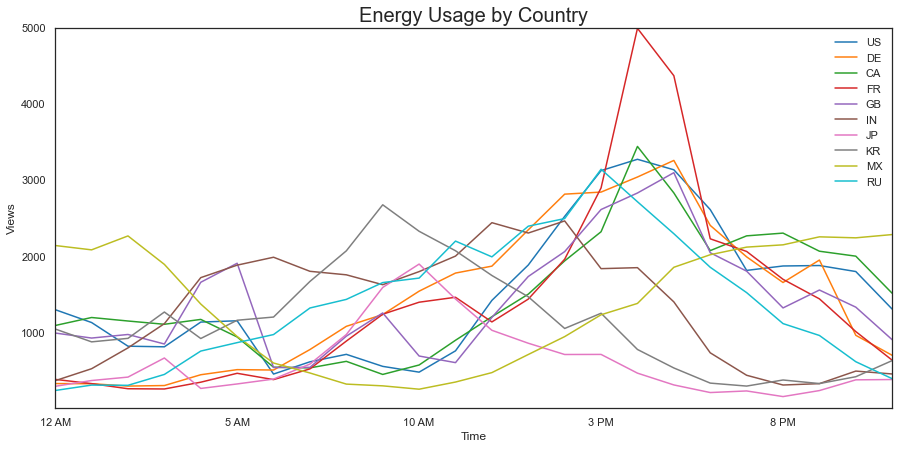

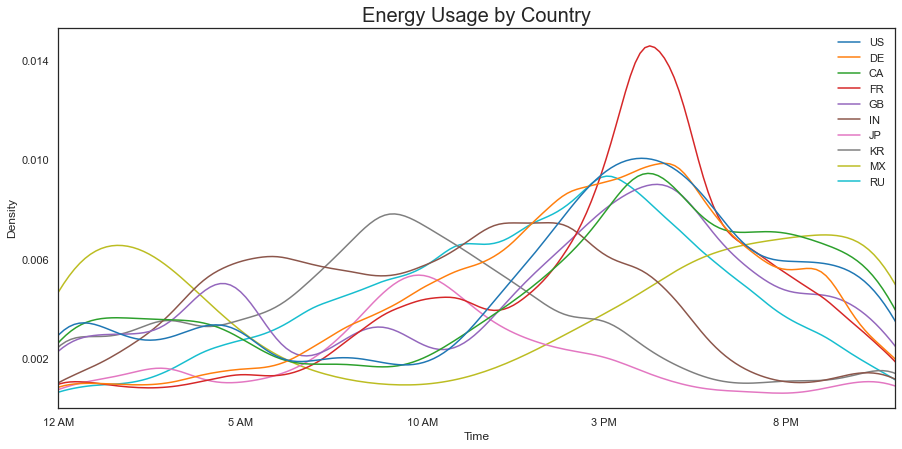

In [73]:
# as we can see, there's a prime correlation between viewership and content publish time.
# Since we'll be analyzing energy usage, I'll be taking advantage of this correlation
# by using publish time to pinpoint peak hours.

data = df.groupby(['country', 'hour']).agg({'views':'count'}).reset_index()
fig1 = sns.lineplot(data = data, x = 'hour', y = 'views', hue = 'country', palette = 'tab10',
            hue_order=countries)

fig1.set(xlim = (0, 23), xlabel = 'Time', 
        ylim = (0, 5e3), ylabel = 'Views',
        xticks = [0, 5, 10, 15, 20],
        xticklabels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM'], 
        yticklabels = ['', 1000, 2000, 3000, 4000, 5000])

plt.legend(frameon = False)
plt.title('Energy Usage by Country', fontsize = 20)
plt.show()

fig2 = sns.kdeplot(data = df, x = 'hour', hue = 'country', palette = 'tab10')
fig2.set(xlim = (0, 23), xlabel = 'Time', 
        xticks = [0, 5, 10, 15, 20], 
        xticklabels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM'],
        yticks = [0.002, 0.006, 0.010, 0.014])

sns.move_legend(fig2, loc = 'upper right', frameon = False, title = '')
plt.title('Energy Usage by Country', fontsize = 20)
plt.show()

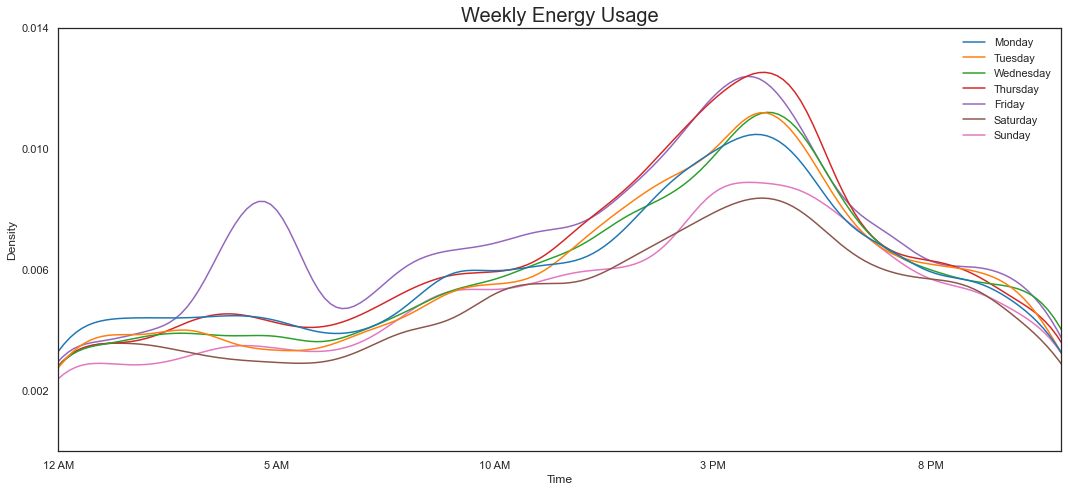

In [74]:
# based on the density plot, we can see peak hours throughout the week
# It feels fairly consistent throughout the mornings, with one exception.
# On Fridays, there seems to be a a massive peak right before 5AM.
# Additionally, the usage density triples from the morning to ~4PM.

hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig = sns.kdeplot(data = df, x = 'hour', hue = 'week', palette = 'tab10', hue_order = hue_order)
fig.set(xlim = (0, 23), xlabel = 'Time', 
        xticks = [0, 5, 10, 15, 20], 
        xticklabels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM'], 
        yticks = [0.002, 0.006, 0.010, 0.014])

sns.move_legend(fig, loc = 'upper right', frameon = False, title = '')
plt.title('Weekly Energy Usage', fontsize = 20)
plt.tight_layout()
plt.savefig('Weekly Energy Usage - Density.png', dpi = 600)
plt.show()

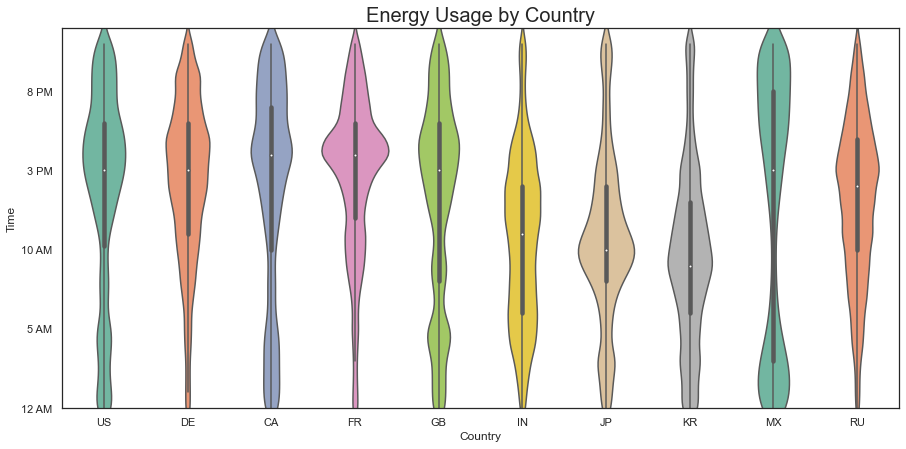

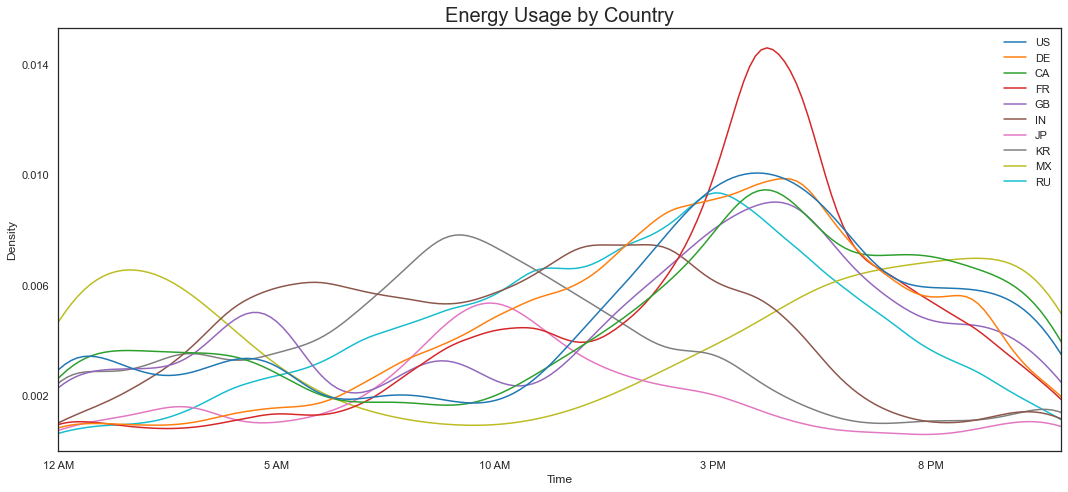

In [75]:
# however, we'd be foolish to think that all countries follow this trend.
# if we group by countries, we can see that the peak hours vary from one country to another

fig1 = sns.violinplot(data = df, x = 'country', y = 'hour', palette = 'Set2')
fig1.set(xlabel = 'Country', 
         ylim=(0, 24), ylabel = 'Time', 
         yticks = [0, 5, 10, 15, 20], 
         yticklabels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM'])

plt.title('Energy Usage by Country', fontsize = 20)
plt.savefig('Energy Usage by Country - Violin.png', dpi = 600)
plt.show()

fig2 = sns.kdeplot(data = df, x = 'hour', hue = 'country', palette = 'tab10')
fig2.set(xlim = (0, 23), xlabel = 'Time', 
        xticks = [0, 5, 10, 15, 20], 
        xticklabels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM'],
        yticks = [0.002, 0.006, 0.010, 0.014])

sns.move_legend(fig2, loc = 'upper right', frameon = False, title = '')
plt.title('Energy Usage by Country', fontsize = 20)
plt.tight_layout()
plt.savefig('Energy Usage by Country - Density.png', dpi = 600)
plt.show()


# usage in france is much higher than the rest of the world ~4PM
# the peak usage in Japan/Korea is ~9AM, whos countries are known for their nightlife
# Mexico peak hours start at 7PM and continues to the early AM
# usage in India is fairly consistent throughout the day, but takes a sharp decline ~8PM

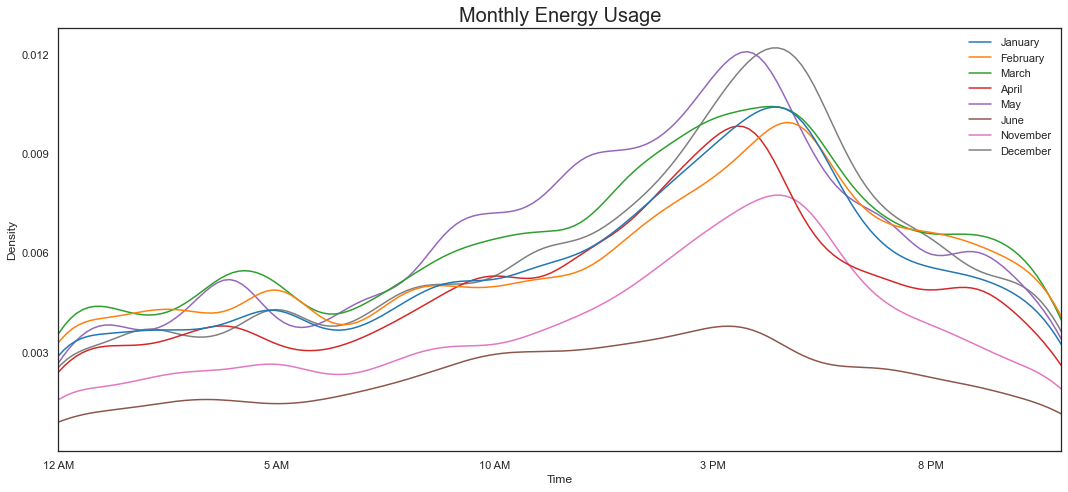

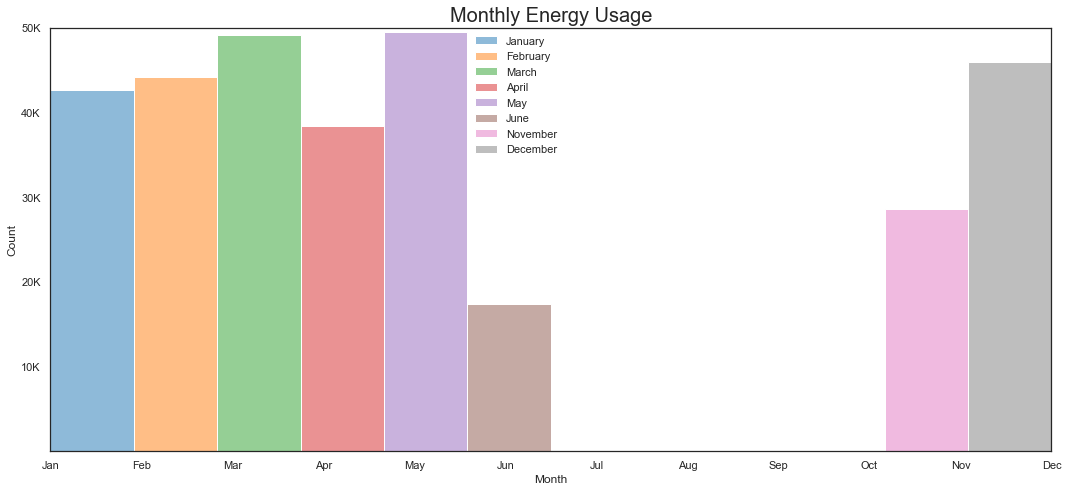

In [90]:
# another metric we can pay attention to would be how the trend continues by month
# unfortunately, the data we have contain months 7-10, which would be extremely valuable!
# it seems that during the summer months, the trend starts to die down.
# this is probably due to graduation and summer vacations
# If there were no missing data, I would expect that the trend would be a bit lower throughout the
# summer, and start picking back up in September

hue_order = ['January', 'February', 'March', 'April', 'May', 'June', 'November', 'December']
fig1 = sns.kdeplot(data = df, x = 'hour', hue = 'month', palette = 'tab10', hue_order = hue_order)
fig1.set(xlim = (0, 23), xlabel = 'Time', 
        xticks = [0, 5, 10, 15, 20], 
        xticklabels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM'],
        yticks = [0.003, 0.006, 0.009, 0.012])

sns.move_legend(fig1, loc = 'upper right', frameon = False, title = '')
plt.title('Monthly Energy Usage', fontsize = 20)
plt.tight_layout()
plt.savefig('Monthly Energy Usage - Density.png', dpi = 600)
plt.show()


fig2 = sns.histplot(data = df, x = df['publish_time'].dt.month, palette='tab10', 
                    bins = 12, hue = 'month', hue_order = hue_order)
fig2.set(xlim = (1, 12), xlabel = 'Month', 
         ylim = (0, 5e4), ylabel = 'Count',
         xticks = range(1, 13), 
         xticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                   'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
         yticks = [0, 1e4, 2e4, 3e4, 4e4, 5e4],
         yticklabels = ['', '10K', '20K', '30K', '40K', '50K'])

sns.move_legend(fig2, loc = (0.42, 0.69), frameon = False, title = '')
plt.title('Monthly Energy Usage', fontsize = 20)
plt.tight_layout()
plt.savefig('Monthly Energy Usage - Histogram.png', dpi = 600)
plt.show()

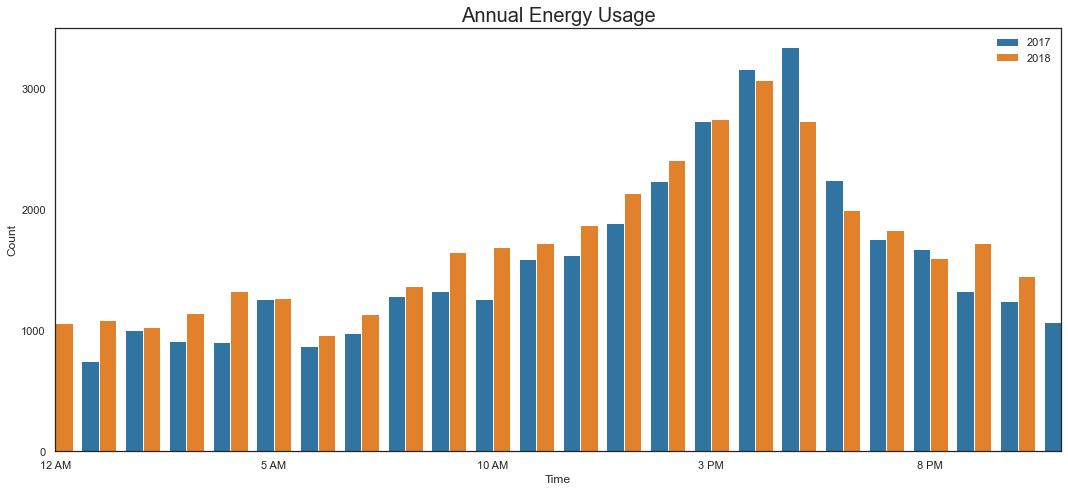

In [93]:
data = df[df['year'].isin([2017, 2018])].groupby(['hour', 'year']).size().reset_index()
data['num_months'] = np.where(data['year'] == 2017, 2, 6)
data.rename(columns = {0: 'count'}, inplace = True)
data['count'] = data['count'] / data['num_months']

fig = sns.barplot(data = data, x = 'hour', y = 'count', hue = 'year', palette = 'tab10')
fig.set(xlim = (0, 23), xlabel = 'Time', 
        ylim = (0, 3500), ylabel = 'Count',
        xticks = [0, 5, 10, 15, 20],
        xticklabels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM'], 
        yticks = [0, 1000, 2000, 3000])
        
        

sns.move_legend(fig, loc = 'upper right', frameon = False, title = '')
plt.title('Annual Energy Usage', fontsize = 20)
plt.tight_layout()
plt.savefig('Annual Energy Usage - Histogram.png', dpi = 600)
plt.show()

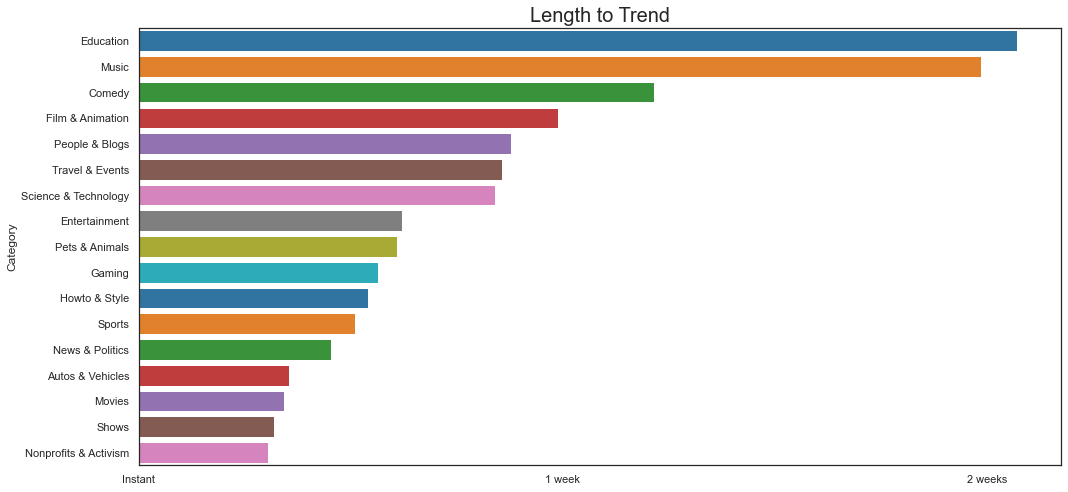

In [92]:
data = df.groupby('category').mean().sort_values('trending_delta', ascending = False).reset_index()
fig = sns.barplot(data = data, x = 'trending_delta', y = 'category', palette = 'tab10')

fig.set(xlabel = '', 
        ylabel = 'Category',
        xticks = [0, 7, 14],
        xticklabels = ['Instant', '1 week', '2 weeks'])
        

# sns.move_legend(fig, loc = 'upper right', frameon = False, title = '')
plt.title('Length to Trend', fontsize = 20)
plt.tight_layout()
plt.savefig('Length to Trend - Bar.png', dpi = 600)
plt.show()

# Let's see if we can use this data to capture buying trends

In [79]:
df.head(1)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year,like_feedback,dislike_feedback,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1


In [95]:
# we can extract all amazon links from the rows

store_df = df[df['description'].str.contains(r'amzn')]
amzn_links = store_df['description'].str.findall(r'amzn.{2,3}\/.{7}')
amzn_links.head(2)

0    [amzn.to/2sTDnRZ, amzn.to/2rUJOmD, amzn.to/2o3...
3                   [amzn.to/2ntNQjM, amzn.to/2ntP1jq]
Name: description, dtype: object

In [96]:
# from here, we can create a new dataframe to see categories that tend to sell most
# this allows us to gain insight on the audience

idx = 0
lst = []
lnk = []

for link in amzn_links:
    lst.extend(map(lambda x: [idx, x], link))
    lnk.append(link)
    idx += 1
    
link_df = pd.DataFrame(lst, columns = ['index', 'link'])
stores = df.drop('description', axis = 1).merge(right = link_df.set_index('index'), how = 'right', 
                                               left_index = True, right_on = 'index')
links = [link for lnk_lst in lnk for link in lnk_lst]

In [123]:
link_df.groupby('index').count().mean()

link    5.636621
dtype: float64

In [97]:
stores.head()

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,category,country,trending_delta,hour,day,week,month,year,like_feedback,dislike_feedback,len_title,len_desc,pct_cap,qty_tags,link
index,,,,,,,,,,,,,,,,,,,,,,,,,
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1,amzn.to/2sTDnRZ
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1,amzn.to/2rUJOmD
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1,amzn.to/2o3GLX5
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1,amzn.to/2nOBmnv
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,People & Blogs,US,1,17,13,Monday,November,2017,28.0,538.0,35,136,100.0,1,amzn.to/2o2cQBT


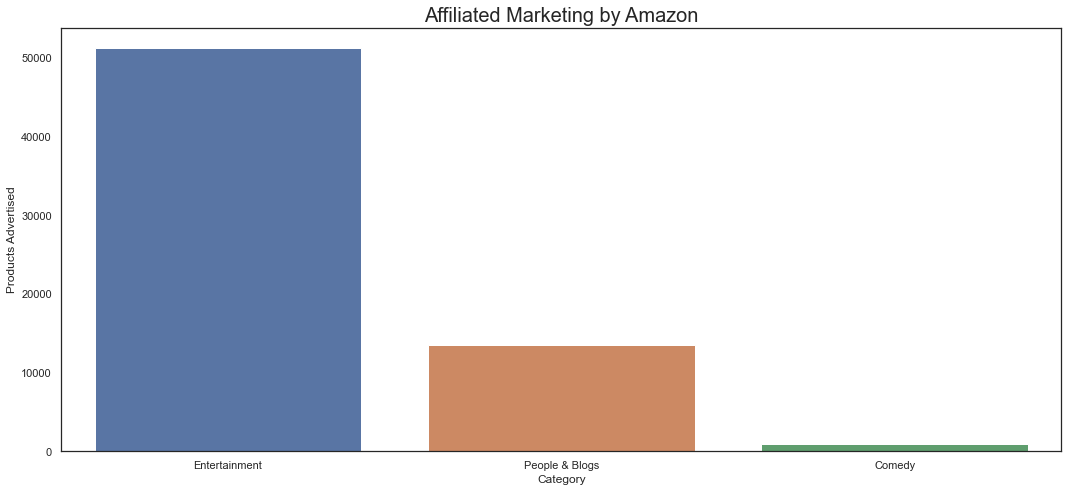

In [99]:
data = stores.groupby('category').count().reset_index().sort_values('link', ascending = False)
fig = sns.barplot(data = data, x = 'category', y = 'link', dodge = False)

fig.set(xlabel = 'Category', 
        ylabel = 'Products Advertised')
        

# sns.move_legend(fig, loc = 'upper right', frameon = False, title = '')
plt.title('Affiliated Marketing by Amazon', fontsize = 20)
plt.tight_layout()
plt.savefig('Affiliated Marketing - Bar.png', dpi = 600)
plt.show()

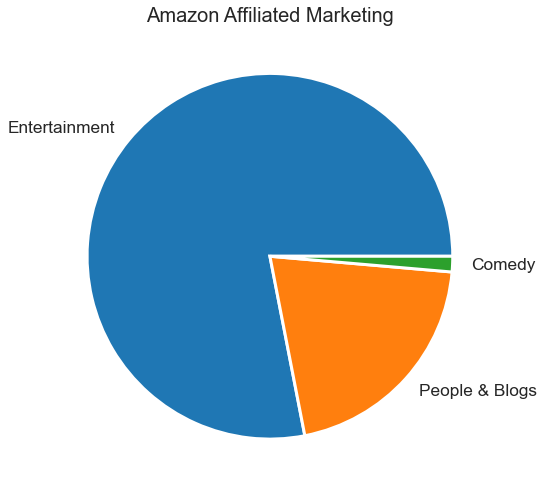

In [100]:
colors = sns.color_palette('tab10')
labels = ['Entertainment', 'People & Blogs', 'Comedy']

plt.pie(data = data, x = 'link', labels = labels, colors = colors,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
        textprops={'size': 'x-large'})
plt.title('Amazon Affiliated Marketing', fontsize = 20)
plt.tight_layout()
plt.savefig('Affiliated Marketing - Pie.png', dpi = 600)
plt.show()

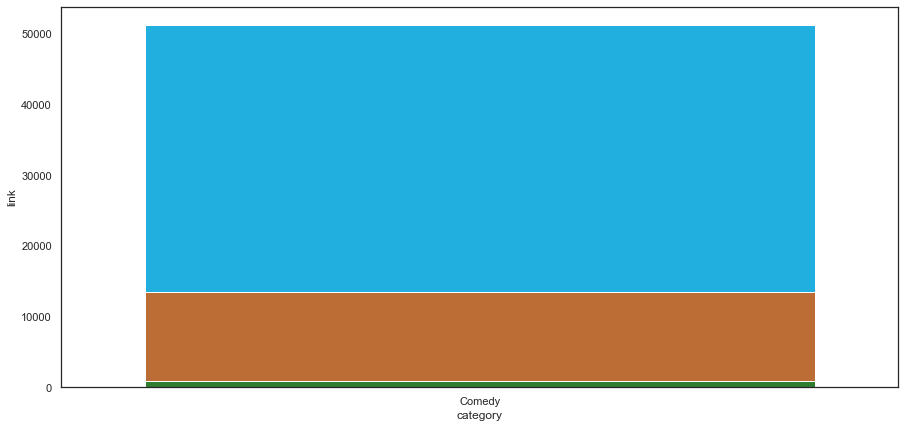

In [86]:
data = stores.groupby('category').count().reset_index().sort_values('link', ascending = False)
fig1 = sns.barplot(data = data[data['category'] == 'Entertainment'],
                   x = 'category', y = 'link', color = 'deepskyblue')
fig2 = sns.barplot(data = data[data['category'] == 'People & Blogs'],
                   x = 'category', y = 'link', color = 'chocolate')
fig3 = sns.barplot(data = data[data['category'] == 'Comedy'],
                   x = 'category', y = 'link', color = 'forestgreen')

In [87]:
HEADERS = ({'User-Agent':
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) \
            Chrome/107.0.0.0 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})

In [88]:
# lets first reduce the amount of links so we don't get duplicates
# but we want to keep track of it

lnk = dict(Counter(links))
len(lnk)

10701

In [47]:
list(lnk.keys())[244:]

['amzn.to/2e1Myqz',
 'amzn.to/2fkiVGJ',
 'amzn.to/2ftNkl8',
 'amzn.to/2kCcIDH',
 'amzn.to/2oX7Eih',
 'amzn.to/2oWRGoD',
 'amzn.to/2f6nL5E',
 'amzn.to/2pbDrN1',
 'amzn.to/2oX63Jz',
 'amzn.to/2ACipdI',
 'amzn.to/2ACiX3g',
 'amzn.to/2jkrYdg',
 'amzn.to/2AEbtwE',
 'amzn.to/2zEMhGo',
 'amzn.to/2zBCUHt',
 'amzn.to/2hX8yr5',
 'amzn.to/2hiy9dE',
 'amzn.to/2xu6rDH',
 'amzn.to/2yw6uxe',
 'amzn.to/2fFLxIc',
 'amzn.to/2yMUUhm',
 'amzn.to/2ywcJ3V',
 'amzn.to/2ynAkqN',
 'amzn.to/2yvBwFe',
 'amzn.to/2jQWb3t',
 'amzn.to/2yw7wt6',
 'amzn.to/2hsnooV',
 'amzn.to/2zqmOCs',
 'amzn.to/2A93eM8',
 'amzn.to/2vlvlC6',
 'amzn.to/2gMrhru',
 'amzn.to/2tqRjBt',
 'amzn.to/2t1NkMh',
 'amzn.to/2uuv9n0',
 'amzn.to/2v3mjcG',
 'amzn.to/2z9AfUq',
 'amzn.to/2hHAOh9',
 'amzn.to/2jLmZSS',
 'amzn.to/2zowm1U',
 'amzn.to/2zcBv95',
 'amzn.to/2hI3Ixs',
 'amzn.to/2hGYRg5',
 'amzn.to/2zVONu0',
 'amzn.to/2zW8thg',
 'amzn.to/2hLuNQh',
 'amzn.to/2zXkROf',
 'amzn.to/2z8ZBl9',
 'amzn.to/2zXCcXb',
 'amzn.to/2iHtu5Z',
 'amzn.to/2AOTrIs',


In [118]:
lnk

[['amzn.to/2sTDnRZ',
  'amzn.to/2rUJOmD',
  'amzn.to/2o3GLX5',
  'amzn.to/2nOBmnv',
  'amzn.to/2o2cQBT',
  'amzn.to/2od5gBJ',
  'amzn.to/2nrdJRO'],
 ['amzn.to/2ntNQjM', 'amzn.to/2ntP1jq'],
 ['amzn.to/2yogsQI'],
 ['amzn.to/2ntNQjM', 'amzn.to/2ntP1jq'],
 ['amzn.to/2yogsQI'],
 ['amzn.to/2bWpQlc'],
 ['amzn.to/2ntNQjM', 'amzn.to/2ntP1jq'],
 ['amzn.to/2bWpQlc'],
 ['amzn.to/2sTDnRZ',
  'amzn.to/2rUJOmD',
  'amzn.to/2o3GLX5',
  'amzn.to/2nOBmnv',
  'amzn.to/2o2cQBT',
  'amzn.to/2od5gBJ',
  'amzn.to/2nrdJRO'],
 ['amzn.to/2ntNQjM', 'amzn.to/2ntP1jq'],
 ['amzn.to/2bWpQlc'],
 ['amzn.to/2sTDnRZ',
  'amzn.to/2rUJOmD',
  'amzn.to/2o3GLX5',
  'amzn.to/2nOBmnv',
  'amzn.to/2o2cQBT',
  'amzn.to/2od5gBJ',
  'amzn.to/2nrdJRO'],
 ['amzn.to/2ntNQjM', 'amzn.to/2ntP1jq'],
 ['amzn.to/2bWpQlc'],
 ['amzn.to/2sTDnRZ',
  'amzn.to/2rUJOmD',
  'amzn.to/2o3GLX5',
  'amzn.to/2nOBmnv',
  'amzn.to/2o2cQBT',
  'amzn.to/2od5gBJ',
  'amzn.to/2nrdJRO'],
 ['amzn.to/2ntNQjM', 'amzn.to/2ntP1jq'],
 ['amzn.to/2bWpQlc'],
 ['amzn.

In [48]:
# # even after reducing it, it will take roughly 10 hours!
# # therefore, i decided to take only the first 100 values.

# idx = 0
# cat = []

# while idx < 100:
#     for link in list(lnk.keys())[244:]:
#         URL = f'http://{list(lnk.keys())[idx]}'
#         webpage = requests.get(URL, headers=HEADERS)
#         soup = BeautifulSoup(webpage.content, "lxml")

#         # in case links are invalid
#         try:
#             cat.append(soup.find("span", attrs={"class":'a-list-item'}).text.strip())
#         except:
#             pass

#         idx += 1

In [117]:
cat.append(cat1)

NameError: name 'cat' is not defined

In [ ]:
pd.DataFrame(cat)[0].value_counts().head(10)

In [116]:
cat1

NameError: name 'cat1' is not defined

In [120]:
idx = 0
lst = []

for item in df_tags['tags']:
    lst.extend(map(lambda x: [idx, x], tag))
    idx += 1
    
tags = pd.DataFrame(lst, columns = ['index', 'tags'])

ValueError: 2 columns passed, passed data had 67 columns